# Kolla nya idéer och features 
### Speciellt för att prioritera mellan hästar i olika lopp
- kelly vs proba
- antal hästar i loppen som feature
- motståndarinfo
  - De tre bäst rankade motståndarna i loppet, deras antal streck
  - genomsnittet av någon ranking för hästarna
  - ...




## 1. En sorterad lista med proba och/eller kelly 
Från den listan plockas hästar tills max insats är nådd, kanske lltid spika en eller två hästar

In [1]:
# # moduler
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from IPython.display import display
# import flaml
# import pickle
# read a model from a file with pickle
# with open('..\\modeller\\FLAML_model.sav', 'rb') as f:
#     flml = pickle.load(f)
# with open('..\\modeller\\FLAML2_model.sav', 'rb') as f:
#     flml2 = pickle.load(f)
    
pd.set_option('display.width', 120)


In [11]:
def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop([ 'startnr', 'avd','vodds', 'podds', 'bins', 'h1_dat',
              'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    if remove_mer:
            df.drop(remove_mer, axis=1, inplace=True)

    return df



med  antal hästar som feature: 0.2396187999030749  
utan antal hästar som feature: 0.23964830518637106  
Minimalt bättre men det är inte vad jag vill uppnå utan bättre viktning mellan hästar i olika lopp

# Tester med olika lösningar 

In [2]:
# moduler
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from IPython.display import display
pd.set_option('display.width', 100)


In [3]:
# skapa data
df = pd.read_csv('..\\all_data.csv')
# Följande datum saknar avd==5 och kan inte användas
saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
df = df[~df.datum.isin(saknas)]
X = df.copy()
X.drop('plac', axis=1, inplace=True)
# X = ordinal_enc(X, 'häst')
y = (df.plac == 1)*1   # plac 1 eller 0


def get_data_for_catboost(X):
    # get numerical features and cat_features
    num_features = list(X.drop('avd', axis=1).select_dtypes(
        include=[np.number]).columns)
    cat_features = list(X.drop('avd', axis=1).select_dtypes(
        include=['object']).columns)
    print(f'Rätt längd på summan (med datum)? {1+len(num_features)+len(cat_features)} == {len(X.columns)}')
    # check cat_features isna
    print('NaN before:', X[cat_features].isna().sum()[X[cat_features].isna().sum() > 0].sort_values(ascending=False).sum())

    # impute 'missing' for all NaN in cat_features
    X[cat_features] = X[cat_features].fillna('missing')
    print('NaN after:', X[cat_features].isna().sum().sum())
    return X, cat_features

X, cat_features = get_data_for_catboost(X)
# cat_features = list(X.drop('avd', axis=1).select_dtypes(include=['object']).columns)
print('cat_features:',cat_features)

# antal hästar per avdeling
def lägg_in_antal_hästar(df_):
    df = df_.copy()
    df['ant_per_lopp'] = None
    df['ant_per_lopp'] = df.groupby(['datum', 'avd'])['avd'].transform('count')
    return df

# mest streck per avdeling
def mest_streck(X_, i, datum, avd):
    X = X_.copy()
    X.sort_values(by=['datum', 'avd', 'streck'], ascending=[
                  True, True, False], inplace=True)
    return X.loc[(X.datum == datum) & (X.avd == avd), 'streck'].iloc[i]

# mest streck per avd som fetures (n bästa)
def lägg_in_motståndare(X_, ant_motståndare):
    X = X_.copy()

    # set X['motståndare1'] to largest streck in every avd
    grouped = X.groupby(['datum', 'avd'])['streck']
    X['motståndare1'] = grouped.transform(max)

    for i in range(2, ant_motståndare+1):
        # set X['motståndare'+str(i)] to ith largest streck in every avd
        X['motståndare' + str(i)] = grouped.transform(lambda x: x.nlargest(i).min())

    return X

# diff streck per avd som fetures (n största diffarna)
def lägg_in_diff_motståndare(X_, motståndare):
    X = X_.copy()

    # set X['motståndare1'] to largest streck in every avd
    grouped = X.groupby(['datum', 'avd'])['streck']
    X['diff1'] = grouped.transform(max) - X.streck

    for i in range(2, motståndare+1):
        # set X['motståndare'+str(i)] to ith largest streck in every avd
        X['diff' + str(i)] = grouped.transform(lambda x: x.nlargest(i).min()) - X.streck

    return X

# Skapa X_train och X_test
def create_X_train_test(X, y, datum):
    X_train = X[X.datum < datum]
    X_test = X[X.datum == datum]
    y_train = y[X.datum < datum]
    y_test = y[X.datum == datum]
    return X_train, X_test, y_train, y_test

#make häst, bana, kusk lower case

for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
    # print(X[f], type(X[f]))
    X[f] = X[f].str.lower()


Rätt längd på summan (med datum)? 78 == 78
NaN before: 369
NaN after: 0
cat_features: ['datum', 'bana', 'häst', 'kusk', 'kön', 'h1_dat', 'h1_kusk', 'h1_bana', 'h2_dat', 'h2_kusk', 'h2_bana', 'h3_dat', 'h3_kusk', 'h3_bana', 'h4_dat', 'h4_kusk', 'h4_bana', 'h5_dat', 'h5_kusk', 'h5_bana']


### Create a model to transform streck to odds
För att använda Kelly mot streck istf vodds

In [15]:
def model_streck_to_odds(X_):
    X = X_.copy()
    # import modules for linear regression
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error as mae
    # import random forest module
    from sklearn.ensemble import RandomForestRegressor
    # X.h1_odds.fillna(0, inplace=True)
    # X.h2_odds.fillna(0, inplace=True)
    X_odds = X.loc[X.vodds <= 40]  # remove outliers
    
    ix_break = int(len(X_odds.datum.unique())*0.75)
    test_start = X_odds.datum.unique()[ix_break]

    X_train, X_test = X_odds[X_odds.datum < test_start], X_odds[X_odds.datum >= test_start]
    y_train, y_test = X_train['vodds'], X_test['vodds']
    X_train=X_train[['streck']].astype(float)
    X_test = X_test[['streck']].astype(float)

    # make a model of RF
    rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=0)
    rf.fit(X_train, y_train)
    y_predrf = rf.predict(X_test)
    # make a model and fit it
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_predlr = linreg.predict(X_test)

    # print the coefficients
    print('Coefficients:', linreg.coef_)
    # print the mean absolute error
    print("LR Mean absolute error: %.2f" % mae(y_test, y_predlr))
    print("RF Mean absolute error: %.2f" % mae(y_test, y_predrf))
    
    return  linreg, rf


linreg,rf = model_streck_to_odds(X)   # used in next cell


Coefficients: [-0.52621488]
LR Mean absolute error: 6.08
RF Mean absolute error: 2.60


In [5]:
def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    import pickle
    # läs in rf_streck_to_odds.pkl
    with open('rf_streck_to_odds.pkl', 'rb') as f:
        rf = pickle.load(f)
        
    if odds is None:
        o = rf.predict(streck.copy())
    else:
        o = rf.predict(streck.copy())

    # for each values > 40 in odds set to 1
    o[o > 40] = 1
    return (o*proba - (1-proba))/o


In [6]:
def compute_total_insats(df):
    insats = 0
    # group by avd
    summa = df.groupby('avd').avd.count().prod() / 2
    return summa

# för en omgång (ett datum) ta ut största diff för streck per avd men bara om diff >= 25 om only_clear
def lista_med_favoriter(df_, ant, only_clear):
    df=df_.copy()
    min_diff = 25 if only_clear else 0
    # sortera på avd,streck
    df = df.sort_values(['avd','streck'], ascending=[False, False])
    diff_list = []
    for avd in range(1,8):
        diff = df.loc[df.avd==avd].streck.iloc[0] - df.loc[df.avd==avd].streck.iloc[1]
        if diff >= min_diff:
            diff_list.append((avd,diff))

     # sortera på diff
    diff_list = sorted(diff_list, key=lambda x: x[1], reverse=True)   
    return diff_list[:ant]

# temp is a list of tuples (avd, diff). check if avd is in the list
def check_avd(avd, temp):
    for t in temp:
        if t[0] == avd:
            return True
    return False   


In [14]:
def spela(df_, max_insats=300, proba=True, kelly=True,ant_favoriter=0,streck=True,only_clear=False):
    df = df_.copy()
    # print('omg df',df.shape)
    dfSpel = pd.DataFrame()
    if proba:
        df = df.sort_values(by='proba', ascending=False)
        if kelly:
            df2 = df.sort_values(by='kelly', ascending=False)
    else:
        df = df.sort_values(by='kelly', ascending=False) # must be kelly
        
    # se till att vi har för alla avd. Välj den bästa per avd
    if proba:
        temp = df.sort_values(by=['proba'], ascending=False)
    else:
        temp = df.sort_values(by=['kelly'], ascending=False)    
    for avd in range(1, 8):
        dfSpel = dfSpel.append(temp[temp.avd == avd].iloc[0])
    #
    favorit_list = lista_med_favoriter(df, ant_favoriter, only_clear)
    curr_insats = 0
    cnt=0
    for index, row in df.iterrows(): 
        if check_avd(row.avd, favorit_list): # Inga fler hästar för avd med en favorit
            continue
        
        dfSpel = dfSpel.append(row)
        # print(dfSpel.shape)
        # print('row',row.shape)
        curr_insats = compute_total_insats(dfSpel)
        if curr_insats > max_insats+30:
            dfSpel = dfSpel.iloc[:-1, :]
            break
        if kelly & proba:
            row2 = df2.iloc[cnt]
            # print('row2',row2.shape)
            dfSpel = dfSpel.append(row2)
            # remove duplicates in dfSpel nd keep the first
        dfSpel = dfSpel.drop_duplicates(subset=['avd', 'häst'], keep='first')
        # print('dfSpel',dfSpel.shape)    
        curr_insats = compute_total_insats(dfSpel)
        if curr_insats > max_insats+30:
            dfSpel = dfSpel.iloc[:-1, :]
            break
        cnt +=1
                
    return dfSpel

# train with curr_datum
def learn(X_train, y_train, X_test, y_test, cat_features,verbose=False):
    train_pool = Pool(X_train.drop('avd', axis=1), label=y_train, cat_features=cat_features)
    test_pool = Pool(X_test.drop('avd', axis=1), label=y_test, cat_features=cat_features)
    cbc = CatBoostClassifier(iterations=1000, loss_function='Logloss', eval_metric='AUC', verbose=verbose)
    cbc.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100,use_best_model=True, verbose=verbose)
    return cbc

def beräkna_utdelning(dfSpel,ant_rätt, df_utdelning):
    if ant_rätt==7:
        slista = list(dfSpel.groupby('avd').avd.count()-1)
        sjuor = 1
        sexor = sum(slista)
        femmor =0
        for avd_ix in range(0, 7):
            for avd2_ix in range(avd_ix+1, 7):
                femmor += slista[avd_ix] * slista[avd2_ix]
    
    elif ant_rätt==6:
        sjuor=0
        avd_list = list(dfSpel.loc[dfSpel.rätt == 'OK']['avd'])  # avd med rätt
        missing = [x for x in range(1, 8) if x not in avd_list]
        sexor = dfSpel.loc[dfSpel.avd == missing[0], 'avd'].count()
        femmor=0
        for avd in avd_list:
            femmor+=dfSpel.loc[dfSpel.avd==avd, 'avd'].count()
        femmor=(femmor-6) * sexor
        
    elif ant_rätt==5:
        sjuor,sexor=0,0
        avd_list = list(dfSpel.loc[dfSpel.rätt == 'OK']['avd'])  # avd med rätt
        missing = [x for x in range(1, 8) if x not in avd_list]
        femmor=dfSpel.loc[dfSpel.avd==missing[0], 'avd'].count() + dfSpel.loc[dfSpel.avd==missing[1], 'avd'].count()
    else:
        sjuor,sexor,femmor = 0,0,0 
           
    datum = dfSpel.iloc[0].datum       
    priser = list(df_utdelning.loc[df_utdelning.datum ==datum, ['7rätt', '6rätt', '5rätt']].values[0])
    return sjuor,sexor,femmor, priser[0]*sjuor+ priser[1]*sexor + priser[2]*femmor

def rätta(y_validate, dfSpel, df_utdelning):
    yindex = y_validate.loc[y == 1].index
    # print(1,_,dfSpel.shape)
    ant_rätt = len(dfSpel.loc[dfSpel.index.isin(yindex)])
    # print(f': total insats {compute_total_insats(dfSpel)} med {dfSpel.shape[0]} spelade hästar: {ant_rätt} rätt')
    dfSpel['rätt'] = ' '
    dfSpel[['avd', 'streck','rätt']]
    dfSpel.loc[dfSpel.index.isin(yindex), 'rätt'] = 'OK'
    # print(2,_,dfSpel.shape)
    return  beräkna_utdelning(dfSpel, ant_rätt, df_utdelning)


## Loop över datum, learn+predict

In [15]:
from sklearn.preprocessing import OrdinalEncoder
def ordinal_enc(df_, features):
    df = df_.copy()
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100000)
    enc.fit(df[[features]])
    df[features] = enc.transform(df[[features]])
    return df, enc


def testa_flera_omg(X_,y_,typ, max_cnt=60,cat_features=cat_features): 
    X = remove_features(X_)
    y = y_.copy()

    # skriv ut parametrar som styr vilken lösning som testas
    max_insats = stats_typer.loc[stats_typer.typ == typ].insats.values[0]
    print('max_insats',max_insats)
    bProba = stats_typer.loc[stats_typer.typ == typ].proba.values[0]
    print('Proba',bProba)
    bKelly = stats_typer.loc[stats_typer.typ == typ].kelly.values[0]
    print('Kelly',bKelly)
    bAnt_hästar = stats_typer.loc[stats_typer.typ == typ].ant_hästar.values[0]
    ant_favoriter = stats_typer.loc[stats_typer.typ == typ].favoriter.values[0]
    only_clear = stats_typer.loc[stats_typer.typ == typ].only_clear.values[0]
    print('ant_favoriter',ant_favoriter, 'only_clear =',only_clear)
    motståndare = stats_typer.loc[stats_typer.typ == typ].motst_info.values[0]
    diff = stats_typer.loc[stats_typer.typ == typ].motst_diff.values[0]
    streck = stats_typer.loc[stats_typer.typ == typ].streck.values[0]
    bEnc = stats_typer.loc[stats_typer.typ == typ].enc.values[0]
    print('encode hästar =',bEnc)
    
    if diff:
        print('Diff motståndare',motståndare)
    else:
        print(motståndare, ' motståndare')
        
    if bAnt_hästar:
        X = lägg_in_antal_hästar(X)
        print('lägg_in_antal_hästar per avd')
     
    if not streck:
        print('not streck')
          
    df_utdelning = pd.read_csv('..\\utdelning.csv')
    datum = df.datum.unique()
    spel_dict = {'typ':[],'datum':[],'insats':[], 'utdelning':[], 'sjuor':[], 'sexor':[], 'femmor':[]}
    kassa=0
    # ix = len(datum)//2+100   Detta ger mitten plus 100
    ix = 71  # ger 71 omgångar som första train data
    if motståndare>0:
        if diff:
            X=lägg_in_diff_motståndare(X, motståndare)
        else:    
            X=lägg_in_motståndare(X, motståndare)
        # print(X)
        
    for cnt,curr_datum in enumerate(datum[ix:-1]):
        # select data
        X_train = X.loc[df.datum<curr_datum].copy()
        y_train = y.loc[df.datum<curr_datum].copy()
        X_test = X.loc[df.datum>curr_datum].copy()
        y_test = y.loc[df.datum>curr_datum].copy()
        X_validate = X.loc[df.datum==curr_datum].copy()
        y_validate = y.loc[df.datum==curr_datum].copy()
        enc = None
        if bEnc:
            X_train, enc = ordinal_enc(X_train, 'häst')
            X_test[['häst']] = enc.transform(X_test[['häst']])
            X_validate[['häst']] = enc.transform(X_validate[['häst']])
            # remove häst from cat_features
            cat_features = [x for x in cat_features if x != 'häst']

        if not streck:
            X_train.drop('streck', axis=1, inplace=True)
            X_test.drop('streck', axis=1, inplace=True)
            # keep in X_validate for kelly formula
        
        # Learn
        cbc = learn(X_train, y_train, X_test, y_test, cat_features)
        
        # predict
        if not streck:
            validate_pool = Pool(X_validate.drop(['avd', 'streck'], axis=1),label=y_validate, cat_features=cat_features)
        else:
            validate_pool = Pool(X_validate.drop(['avd'], axis=1), label=y_validate, cat_features=cat_features)
        
        X_validate['proba'] = cbc.predict_proba(validate_pool)[:, 1]
        X_validate['kelly'] = kelly(X_validate.proba, X_validate[['streck']], None)
        
        # Spela
        dfSpel = spela(X_validate, max_insats=max_insats, proba=bProba, kelly=bKelly, 
                       ant_favoriter=ant_favoriter,streck=streck,only_clear=only_clear)
        
        # Rätta
        sjuor, sexor, femmor, utdelning = rätta(y_validate, dfSpel, df_utdelning)
        insats = compute_total_insats(dfSpel) 
        ant_spelade = dfSpel.shape[0]
        kassa += utdelning-insats
        print(f'{curr_datum} - insats: {insats}, ant spel: {ant_spelade}, rätt=({sjuor},{sexor},{femmor}), Utd: {utdelning}  :\tkassa: {kassa}')
        # append insats, utdelning, sjuor to spel_dict['datum']
        spel_dict['typ'].append(typ)
        spel_dict['datum'].append(curr_datum)
        spel_dict['insats'].append(insats)
        spel_dict['utdelning'].append(utdelning)
        spel_dict['sjuor'].append(sjuor)
        spel_dict['sexor'].append(sexor)
        spel_dict['femmor'].append(femmor)
        
        if cnt+1>=max_cnt:
            break

    print('Finished')
    return spel_dict,dfSpel    


stats_typer = pd.DataFrame(columns=['typ', 'insats', 'ant_hästar', 'proba', 'kelly', 'motst_diff', 'motst_info', 'favoriter','only_clear', 'streck','enc'])

stats_typer.loc[len(stats_typer)] =  [1, 300, False,  True, False,  True, 2, 2,  True, False, False]
stats_typer.loc[len(stats_typer)] =  [2, 300, False, False,  True, False, 0, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] =  [3, 300, False,  True,  True, False, 0, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] =  [4, 300,  True, False,  True, False, 0, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] =  [5, 300,  True,  True,  True, False, 2, 2,  True,  True, False]
stats_typer.loc[len(stats_typer)] =  [6, 300,  True,  True, False, False, 0, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] =  [7, 300,  True,  True,  True, False, 0, 2, False,  True, False]
stats_typer.loc[len(stats_typer)] =  [8, 300,  True,  True,  True, False, 2, 2, False,  True, False]
stats_typer.loc[len(stats_typer)] =  [9, 300,  True,  True,  True,  True, 2, 2,  True,  True, False]
stats_typer.loc[len(stats_typer)] = [10, 300, False,  True, False, False, 0, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] = [11, 300,  True,  True,  True, False, 1, 2, False,  True, False]
stats_typer.loc[len(stats_typer)] = [12, 300,  True,  True,  True,  True, 2, 2,  True, False, False]
stats_typer.loc[len(stats_typer)] = [13, 300,  True,  True,  True, False, 3, 2, False,  True, False]
stats_typer.loc[len(stats_typer)] = [14, 300,  True,  True,  True,  True, 1, 2, False,  True, False]
stats_typer.loc[len(stats_typer)] = [15, 300,  True,  True,  True, False, 0, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] = [16, 300,  True,  True,  True,  True, 2, 2, False,  True, False]
stats_typer.loc[len(stats_typer)] = [17, 300,  True,  True,  True, False, 3, 0, False,  True, False]
stats_typer.loc[len(stats_typer)] = [18, 300,  True,  True,  True, False, 1, 1, False,  True, False]
stats_typer.loc[len(stats_typer)] = [19, 300,  True,  True,  True, False, 0, 0, False, False, False]
stats_typer.loc[len(stats_typer)] = [20, 300,  True,  True,  True,  True, 3, 2,  True,  True, False]
stats_typer.loc[len(stats_typer)] = [21, 300,  True,  True,  True,  True, 3, 2, False,  True, False]

stats_typer[['typ', 'insats',  'motst_info', 'favoriter', ]] = stats_typer[['typ', 'insats',  'motst_info', 'favoriter', ]].astype(int)

stats_typer

### motst_dif: Använd diff till motståndare istf absoluta värden
### only_clear: Ta endast med favoriter som är solklara (om favoriter>0)
### motst_info: ta n st med mest streck i loppet


,typ,insats,ant_hästar,proba,kelly,motst_diff,motst_info,favoriter,only_clear,streck,enc
0,1,300,False,True,False,True,2,2,True,False,False
1,2,300,False,False,True,False,0,0,False,True,False
2,3,300,False,True,True,False,0,0,False,True,False
3,4,300,True,False,True,False,0,0,False,True,False
4,5,300,True,True,True,False,2,2,True,True,False
5,6,300,True,True,False,False,0,0,False,True,False
6,7,300,True,True,True,False,0,2,False,True,False
7,8,300,True,True,True,False,2,2,False,True,False
8,9,300,True,True,True,True,2,2,True,True,False
9,10,300,False,True,False,False,0,0,False,True,False


In [20]:
# for cnt,typ in enumerate(['21', '6', '4', '3', '16', '2', '8', '13', '17', '5', '11', '20', '10',
#        '7', '1', '14', '9', '12', '19', '18', '15']):
#     stats_typer.loc[stats_typer.typ == typ,['typ']]=cnt+1
   #  print(stats_typer.loc[stats_typer.typ==typ].values)
    
# stats_typer.loc[stats_typer.typ == '1', ['typ']] = '1'
# stats_typer.sort_values(by=['typ'], inplace=True)
# s_t = stats_typer.copy()
# for row in s_t.values:#.iterrows():
#    print(f"stats_typer.loc[len(stats_typer)]=[{row[0]}, 300, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]},{row[7]}, {row[8]}, {row[9]}, {row[10]}]")
stats_typer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   typ         21 non-null     int32 
 1   insats      21 non-null     int32 
 2   ant_hästar  21 non-null     object
 3   proba       21 non-null     object
 4   kelly       21 non-null     object
 5   motst_diff  21 non-null     object
 6   motst_info  21 non-null     int32 
 7   favoriter   21 non-null     int32 
 8   only_clear  21 non-null     object
 9   streck      21 non-null     object
 10  enc         21 non-null     object
dtypes: int32(4), object(7)
memory usage: 1.6+ KB


## Kör tester

In [16]:
def run_one_typ(typ):
    spel_dict, dfSpel = testa_flera_omg(X,y, typ, 1000)
    temp_stats = pd.DataFrame(spel_dict)
    # temp_stats.typ=temp_stats.typ.astype('string') 
    return spel_dict, temp_stats, dfSpel

In [17]:
def beräkna_kassa(spel_stats):
    spel_stats['vinst'] = spel_stats['utdelning'] - spel_stats['insats']
    spel_stats['kassa'] = spel_stats.groupby(by='typ')['vinst'].cumsum()
    return spel_stats

def uppdatera_spel_stats(temp_stats):
    spel_stats = pd.read_csv('spel_stats.csv')
    spel_stats = pd.concat([spel_stats, temp_stats], ignore_index=True)
    spel_stats.drop_duplicates(subset=['typ', 'datum'], keep='last', inplace=True)
    spel_stats = beräkna_kassa(spel_stats)
    spel_stats.to_csv('spel_stats.csv', index=False)
    return spel_stats

def bästa_kassa(stats):
    typlista = []
    for typ in stats.typ.unique():
        row = stats.loc[stats.typ == typ]
        kassa = row.utdelning.sum()-row.insats.sum()
        typlista.append((typ, kassa))
        
    typlista.sort(key=lambda x: x[1], reverse=True)
    print(typlista)

In [ ]:
# for typ in stats_typer.typ[7:10]:    # Börja med de 10 första
for typ in [6]+list(range(11, 22)):    # fortsätt med resten och ta om 6
    print('Running typ: ', typ)
    spel_dict, temp_stats, dfSpel = run_one_typ(typ)
    spel_stats = uppdatera_spel_stats( temp_stats)
    bästa_kassa(spel_stats)


In [18]:
# spel_stats.sort_values(by=['typ', 'datum'], inplace=True)
spel_stats = pd.read_csv('spel_stats.csv')
spel_stats

,typ,datum,insats,utdelning,sjuor,sexor,femmor,kassa,year,vinst
0,1,2016-01-02,324.0,94520,1,12,59,94196.0,NaN,94196.0
1,1,2016-01-09,288.0,0,0,0,0,93908.0,NaN,-288.0
2,1,2016-01-16,288.0,0,0,0,0,93620.0,NaN,-288.0
3,1,2016-01-23,288.0,0,0,0,0,93332.0,NaN,-288.0
4,1,2016-01-30,288.0,267,0,0,3,93311.0,NaN,-21.0
...,...,...,...,...,...,...,...,...,...,...
11595,25,2022-01-15,288.0,132,0,2,20,-44024.0,NaN,-156.0
11596,25,2022-01-22,288.0,240,0,0,5,-44072.0,NaN,-48.0
11597,25,2022-01-29,288.0,51,0,0,3,-44309.0,NaN,-237.0
11598,25,2022-02-05,288.0,60,0,0,4,-44537.0,NaN,-228.0


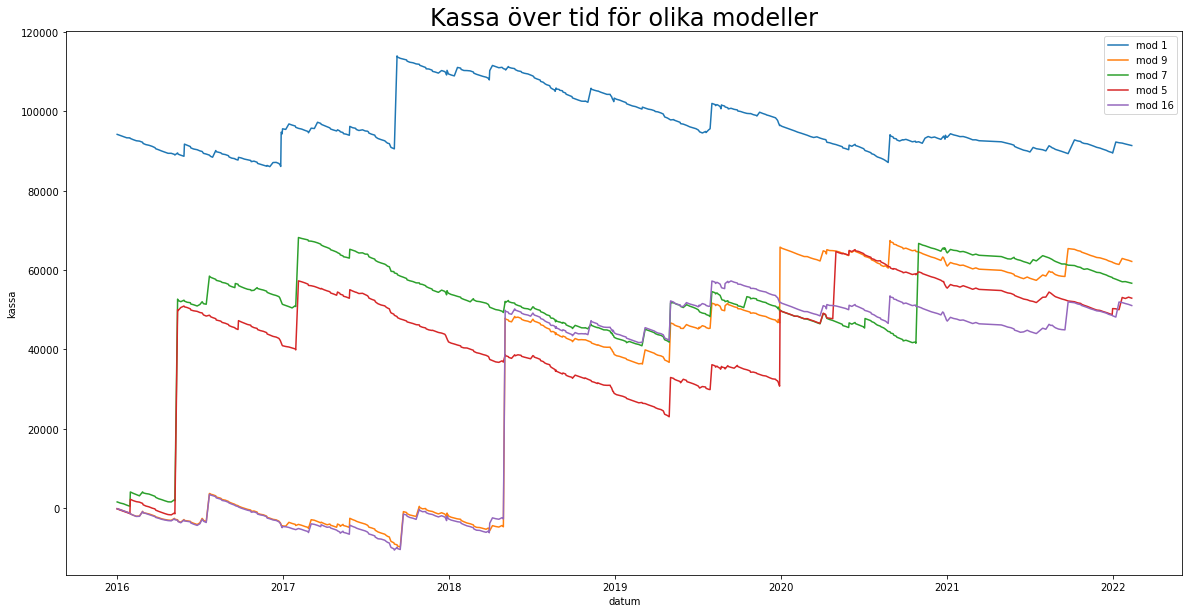

In [27]:
# plot spel_stats kassa over time
def plot_spel_stats_over_time(spel_stats, typ_list:list):
    
    spel_stats = pd.read_csv('spel_stats.csv')
    import matplotlib.pyplot as plt
    import seaborn as sns

    spel_stats.datum=pd.to_datetime(spel_stats.datum)
    spel_stats.sort_values(by='datum', inplace=True)
    spel_stats['year'] = spel_stats.datum.dt.year

    fig, ax = plt.subplots(figsize=(20,10))
    for t in typ_list:
        sns.lineplot(x='datum', y='kassa', data=spel_stats[spel_stats.typ==t], label='mod '+str(t))
    plt.legend()
    plt.title('Kassa över tid för olika modeller', fontsize=24)
    plt.show()


plot_spel_stats_over_time(spel_stats, [1,9,7,5,16])


In [19]:
def stats_for_typ(typ,stats):
    stats_row = stats.loc[stats.typ == typ]
    print(stats_row[['insats','utdelning','sjuor','sexor','femmor']].sum())
    print(f'Kassa (typ={typ}):',stats_row.utdelning.sum()-stats_row.insats.sum())
stats_for_typ(1,spel_stats)    
# spel_stats.info()

insats       133048.0
utdelning    224432.0
sjuor            31.0
sexor           597.0
femmor         4808.0
dtype: float64
Kassa (typ=1): 91384.0


In [20]:
spel_sort = spel_stats.groupby('typ')[['sjuor','sexor','femmor','insats','vinst']].sum().sort_values(by='vinst', ascending=False)
valda=spel_sort.loc[spel_sort.vinst>-0].index
valda[:6]

Int64Index([1, 9, 7, 5, 16, 6], dtype='int64', name='typ')

## Väljer ut de bästa för mer tester

In [21]:

valda = spel_sort.iloc[:4].index.tolist()
print(valda)
# create new rows from valda but with enc = True

for typ in valda:
    l = stats_typer.loc[stats_typer.typ == typ].values[0].tolist()
    
    # set first item in l to len(stats_typer)+1 as a string and last item to true
    l[0] = str(len(stats_typer)+1)
    l[-1] = True
    
    stats_typer.loc[len(stats_typer)] = l

stats_typer


[1, 9, 7, 5]


,typ,insats,ant_hästar,proba,kelly,motst_diff,motst_info,favoriter,only_clear,streck,enc
0,1,300,False,True,False,True,2,2,True,False,False
1,2,300,False,False,True,False,0,0,False,True,False
2,3,300,False,True,True,False,0,0,False,True,False
3,4,300,True,False,True,False,0,0,False,True,False
4,5,300,True,True,True,False,2,2,True,True,False
5,6,300,True,True,False,False,0,0,False,True,False
6,7,300,True,True,True,False,0,2,False,True,False
7,8,300,True,True,True,False,2,2,False,True,False
8,9,300,True,True,True,True,2,2,True,True,False
9,10,300,False,True,False,False,0,0,False,True,False


### run test for valda stats_typer

In [ ]:
for typ in stats_typer.iloc[-len(valda):,:].typ:
   print('Vald typ: ', typ)
   spel_dict, temp_stats, dfSpel = run_one_typ(typ)
   temp_stats['vinst'] = temp_stats.utdelning-temp_stats.insats
   # temp_stats['kassa'] = temp_stats.vinst.cumsum()

   spel_stats = uppdatera_spel_stats(temp_stats)

In [22]:
bästa_kassa(spel_stats)


[(1, 91384.0), (9, 62166.0), (7, 56673.0), (5, 52910.0), (16, 51052.0), (6, 38470.0), (8, 34861.0), (3, 26577.0), (2, 22652.0), (17, 6276.5), (14, 2509.0), (10, -139.0), (18, -15911.0), (22, -16140.0), (23, -18330.0), (11, -19430.5), (21, -19742.0), (15, -21237.0), (20, -21804.0), (13, -23795.0), (12, -33721.5), (24, -38094.0), (19, -40145.5), (4, -40979.5), (25, -44644.0)]


In [23]:
# spel_stats['vinst'] = spel_stats.utdelning-spel_stats.insats
spel_sort = spel_stats.groupby('typ')[['sjuor', 'sexor', 'femmor', 'insats', 'vinst']].sum().sort_values(by='vinst', ascending=False)
valda = spel_sort.loc[spel_sort.vinst > 0].iloc[:10].index.tolist()
valda


[1, 9, 7, 5, 16, 6, 8, 3, 2, 17]

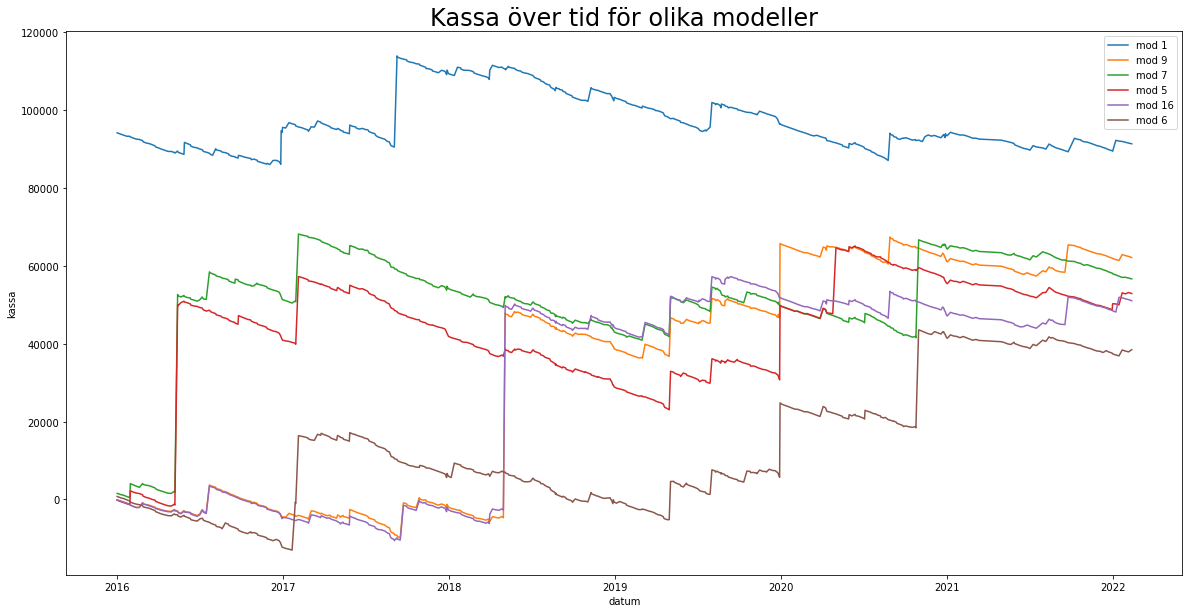

In [28]:
# valda_int = [int(x) for x in valda]
plot_spel_stats_over_time(spel_stats, valda[:6])


In [29]:
# spel_stats['vinst'] = spel_stats.utdelning-spel_stats.insats
print('antal omgångar', spel_stats.datum.unique().shape[0])
spel_stats.groupby('typ')[['sjuor', 'sexor', 'femmor', 'insats', 'vinst']].sum().sort_values(by='sjuor', ascending=False)
# spel_stats.loc[(spel_stats.typ == 6) & (spel_stats.year==2018)].tail(60)

antal omgångar 464


,sjuor,sexor,femmor,insats,vinst
typ,,,,,
6,33,571,4280,136399.0,38470.0
1,31,597,4808,133048.0,91384.0
16,28,504,3962,132974.0,51052.0
9,28,503,3947,133164.0,62166.0
7,27,471,3678,134960.0,56673.0
13,27,505,3978,133040.0,-23795.0
10,26,514,4044,134722.0,-139.0
14,26,485,3802,133842.0,2509.0
22,25,526,4539,130677.0,-16140.0


### Alla valda blev sämre än sina föregångare som hade enc=False
Nu är det dags för att hitta kluster i spel_stats

In [30]:
stats_typer.columns
# from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
# data=load_digits().data
# pca = PCA(3)
# df2=pca.fit_transform(data)
# df2

[2 0 0 0 1 0 3 1 1 0 3 2 1 3 0 1 1 3 0 1 1 2 1 3 1]


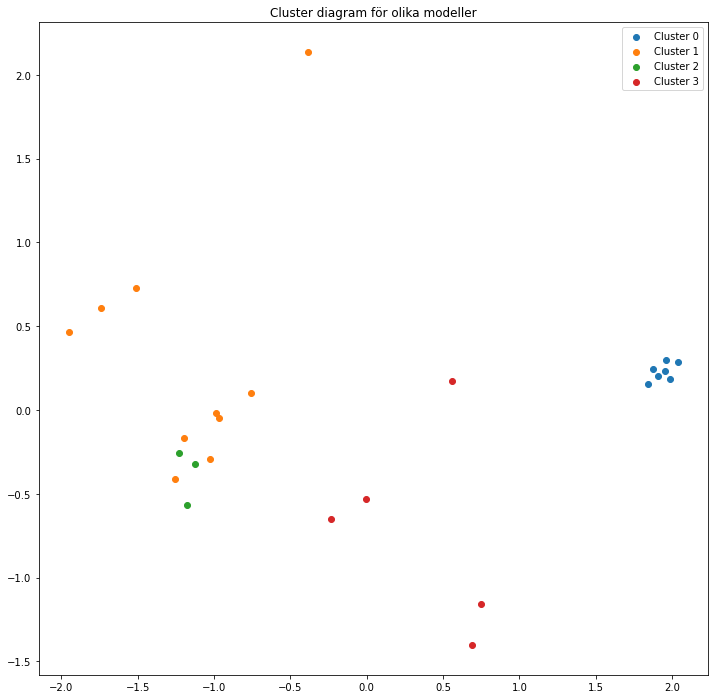

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

cluster_data = stats_typer[['ant_hästar', 'proba', 'kelly', 'motst_diff', 'motst_info', 'favoriter',
                           'only_clear', 'streck', 'enc']]
#Initialize the class object
nCluster=4
kmeans = KMeans(n_clusters=nCluster)

pca = PCA(nCluster)
df3=pca.fit_transform(cluster_data)
# df3 = cluster_data
# print(df3)
#predict the labels of clusters.
label = kmeans.fit_predict(df3)

print(label)

#filter rows of original data
plt.figure(figsize=(12, 12))

filtered_label=list(range(nCluster))
for c in range(nCluster):
    filtered_label[c] = df3[label == c]
    # print(f"Cluster {c}: {filtered_label[c]}")
    plt.scatter(filtered_label[c][:, 0], filtered_label[c][:,1], label='Cluster '+str(c))
plt.title('Cluster diagram för olika modeller')
plt.legend()
plt.show()


# y_pred = KMeans(n_clusters=3, random_state=2022).fit_predict(cluster_data)

# print(y_pred)
# # plt.subplot(221)
# plt.bar(cluster_data.iloc[:, 1], y=y_pred)
# plt.title("Incorrect Number of Blobs")


In [32]:
stats_typer['label'] = label
spel_res = spel_stats.groupby('typ')[['sjuor', 'sexor', 'femmor', 'insats', 'vinst']].sum()
spel_res.index = spel_res.index.astype(int)
spel_res.sort_index(inplace=True)
spel_res['cluster'] = label
display(spel_res.groupby('cluster')[['sjuor', 'sexor', 'femmor', 'vinst']].mean())
display(spel_res.sort_values(by=['cluster','vinst'],ascending=[True,False]))

,sjuor,sexor,femmor,vinst
cluster,,,,
0,18.571429,364.571429,3043.285714,-2114.571429
1,23.000000,444.400000,3648.500000,7895.050000
2,25.666667,514.666667,4290.666667,13840.833333
3,23.200000,438.000000,3564.000000,-2850.700000


,sjuor,sexor,femmor,insats,vinst,cluster
typ,,,,,,
6,33,571,4280,136399.0,38470.0,0
3,19,379,3223,133084.0,26577.0,0
2,10,201,1859,130267.0,22652.0,0
10,26,514,4044,134722.0,-139.0,0
15,16,341,3011,133608.0,-21237.0,0
19,15,325,2955,133514.5,-40145.5,0
4,11,221,1931,127382.5,-40979.5,0
9,28,503,3947,133164.0,62166.0,1
5,22,439,3632,133815.0,52910.0,1


In [33]:
print('Antal hästlopp',spel_stats.shape[0])
typer = stats_typer[['typ','ant_hästar', 'proba', 'kelly', 'motst_diff', 'motst_info', 'favoriter','only_clear', 'streck', 'enc']].copy()
typer.set_index('typ', inplace=True)
result = spel_res.groupby('typ')[['sjuor', 'sexor', 'femmor', 'vinst']].sum()
typer.index = typer.index.astype(int)
tot_stat = pd.concat([typer, result], axis=1).sort_values(by=['sjuor','ant_hästar', 'proba', 'kelly',
                                                   'motst_info', 'favoriter', 'only_clear', 'streck', 'motst_diff', 'enc', ], ascending=False)
tot_stat


Antal hästlopp 11600


,ant_hästar,proba,kelly,motst_diff,motst_info,favoriter,only_clear,streck,enc,sjuor,sexor,femmor,vinst
typ,,,,,,,,,,,,,
6,True,True,False,False,0,0,False,True,False,33,571,4280,38470.0
1,False,True,False,True,2,2,True,False,False,31,597,4808,91384.0
9,True,True,True,True,2,2,True,True,False,28,503,3947,62166.0
16,True,True,True,True,2,2,False,True,False,28,504,3962,51052.0
13,True,True,True,False,3,2,False,True,False,27,505,3978,-23795.0
7,True,True,True,False,0,2,False,True,False,27,471,3678,56673.0
14,True,True,True,True,1,2,False,True,False,26,485,3802,2509.0
10,False,True,False,False,0,0,False,True,False,26,514,4044,-139.0
22,False,True,False,True,2,2,True,False,True,25,526,4539,-16140.0


In [34]:
display(tot_stat.groupby('ant_hästar')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.groupby('proba')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.groupby('kelly')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.loc[tot_stat.motst_info!=0].groupby('motst_diff')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.groupby('motst_info')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.groupby('favoriter')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.loc[tot_stat.favoriter>0].groupby('only_clear')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.groupby('streck')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))
display(tot_stat.groupby('enc')[['sjuor', 'sexor', 'femmor', 'vinst']].mean().sort_values(by='sjuor', ascending=False))

display('Förvånande: Kelly samt ant_hästar inte bra och streck bara oklart bättre')
display('kör några där enbart kelly > 0 används')

,sjuor,sexor,femmor,vinst
ant_hästar,,,,
False,22.2,443.40,3694.60,24866.800
True,22.1,425.65,3500.35,-1645.825


,sjuor,sexor,femmor,vinst
proba,,,,
True,23.130435,448.173913,3682.173913,4771.521739
False,10.500000,211.000000,1895.000000,-9163.750000


,sjuor,sexor,femmor,vinst
kelly,,,,
False,28.750000,552.000000,4417.750000,28393.750000
True,20.857143,405.809524,3371.857143,-1055.119048


,sjuor,sexor,femmor,vinst
motst_diff,,,,
True,24.777778,477.777778,3907.555556,10819.277778
False,22.000000,433.000000,3583.000000,-1390.428571


,sjuor,sexor,femmor,vinst
motst_info,,,,
2,24.222222,471.666667,3883.444444,19948.611111
1,23.333333,447.666667,3630.666667,-10944.166667
3,22.250000,435.750000,3601.500000,-14766.125000
0,19.555556,377.666667,3136.777778,419.666667


,sjuor,sexor,femmor,vinst
favoriter,,,,
2,23.875,459.8125,3769.4375,7240.8750
1,20.000,395.0000,3321.0000,-15911.0000
0,18.875,372.2500,3106.0000,-1065.6875


,sjuor,sexor,femmor,vinst
only_clear,,,,
False,23.777778,449.666667,3650.111111,3124.722222
True,23.500000,463.125000,3847.625000,8977.562500


,sjuor,sexor,femmor,vinst
streck,,,,
False,23.000000,467.250000,3956.750000,344.250000
True,21.952381,421.952381,3459.666667,4287.642857


,sjuor,sexor,femmor,vinst
enc,,,,
False,22.285714,429.190476,3514.571429,9934.547619
True,21.250000,429.250000,3668.500000,-29302.000000


'Förvånande: Kelly samt ant_hästar inte bra och streck bara oklart bättre'

'kör några där enbart kelly > 0 används'

# Ta fram veckans rad för min bästa typ
Just nu: 6, 1, 9 och 16 är kandidater. Väljer 1 eller 6 som har 31 resp 33 sjuor

In [35]:
datum = df.datum.unique()
# print('senaste' ,datum[-1])
# learn all datum from 2018 to datum[-145]
print(f'train until {datum[-100]} \t\t   {len(datum[:-100])} omgångar ')
print(f'test from {datum[-100]} to {datum[-2]} {len(datum[-100:-2])} omgångar')
print(f'ta fram rad för {datum[-1]}')


train until 2020-07-11 		   436 omgångar 
test from 2020-07-11 to 2022-02-12 98 omgångar
ta fram rad för 2022-02-19


In [36]:
def sista_veckan(X_, y_, typ, max_cnt=60, cat_features=cat_features):
    X=X_.copy()
    y=y_.copy()
    max_insats = stats_typer.loc[stats_typer.typ == typ].insats.values[0]
    print('max_insats',max_insats)
    bProba = stats_typer.loc[stats_typer.typ == typ].proba.values[0]
    print('Proba',bProba)
    bKelly = stats_typer.loc[stats_typer.typ == typ].kelly.values[0]
    print('Kelly',bKelly)
    bAnt_hästar = stats_typer.loc[stats_typer.typ == typ].ant_hästar.values[0]
    ant_favoriter = stats_typer.loc[stats_typer.typ == typ].favoriter.values[0]
    only_clear = stats_typer.loc[stats_typer.typ == typ].only_clear.values[0]
    print('ant_favoriter',ant_favoriter, 'only_clear =',only_clear)
    motståndare = stats_typer.loc[stats_typer.typ == typ].motst_info.values[0]
    diff = stats_typer.loc[stats_typer.typ == typ].motst_diff.values[0]
    streck = stats_typer.loc[stats_typer.typ == typ].streck.values[0]
    print('streck',streck)
    bEnc = stats_typer.loc[stats_typer.typ == typ].enc.values[0]
    print('encode hästar =',bEnc)
    
    if diff:
        print('Diff motståndare',motståndare)
    else:
        print(motståndare, ' motståndare')
        
    if bAnt_hästar:
        X = lägg_in_antal_hästar(X)
        print('lägg_in_antal_hästar per avd')
     
    if not streck:
        print('not streck')
          
    df_utdelning = pd.read_csv('..\\utdelning.csv')
    datum = df.datum.unique()
    # spel_dict = {'typ':[],'datum':[],'insats':[], 'utdelning':[], 'sjuor':[], 'sexor':[], 'femmor':[]}
    # kassa=0
    # ix = len(datum)//2+100   Detta ger mitten plus 100
    # ix = 71  # ger 71 omgångar som första train data
    if motståndare>0:
        if diff:
            X=lägg_in_diff_motståndare(X, motståndare)
        else:    
            X=lägg_in_motståndare(X, motståndare)
        # print(X)
        
    train_datum = datum[-100]  
    test_datum= datum[-100]
    curr_datum = datum[-1]
    # select data
    X_train = X.loc[X.datum < train_datum].copy()
    y_train = y.loc[X.datum < train_datum].copy()
    X_test = X.loc[(X.datum >= test_datum) & (X.datum < curr_datum)].copy()
    y_test = y.loc[(X.datum >= test_datum) & (X.datum < curr_datum)].copy()
    X_validate = X.loc[X.datum==curr_datum].copy()
    y_validate = y.loc[X.datum==curr_datum].copy()
    enc = None
    if bEnc:
        X_train, enc = ordinal_enc(X_train, 'häst')
        X_test[['häst']] = enc.transform(X_test[['häst']])
        X_validate[['häst']] = enc.transform(X_validate[['häst']])
        # remove häst from cat_features
        cat_features = [x for x in cat_features if x != 'häst']

    if not streck:
        X_train.drop('streck', axis=1, inplace=True)
        X_test.drop('streck', axis=1, inplace=True)
        # keep in X_validate for kelly formula
    
    # Learn
    cbc = learn(X_train, y_train, X_test, y_test, cat_features)
    
    # predict
    if not streck:
        validate_pool = Pool(X_validate.drop(['avd', 'streck'], axis=1),label=y_validate, cat_features=cat_features)
    else:
        validate_pool = Pool(X_validate.drop(['avd'], axis=1), label=y_validate, cat_features=cat_features)
    
    X_validate['proba'] = cbc.predict_proba(validate_pool)[:, 1]
    X_validate['kelly'] = kelly(X_validate.proba, X_validate[['streck']], None)
    
    # Spela
    dfSpel = spela(X_validate, max_insats=max_insats, proba=bProba, kelly=bKelly, 
                    ant_favoriter=ant_favoriter,streck=streck,only_clear=only_clear)
    
    # Rätta
    sjuor, sexor, femmor, utdelning = rätta(y_validate, dfSpel, df_utdelning)
    print(sjuor,sexor,femmor)
    ant_spelade = dfSpel.shape[0]
    # sort by avd
    # display(dfSpel.sort_values(by='proba'),ascending=False)
    
    return dfSpel

In [187]:
[6,1,9,16]
dfSpel=sista_veckan( X, y, 16)   

max_insats 300
Proba True
Kelly True
ant_favoriter 2 only_clear = False
streck True
encode hästar = False
Diff motståndare 2
lägg_in_antal_hästar per avd
0 0 0


In [185]:
# dfSpel.sort_values(by='proba',ascending=False)
dfSpel.sort_values(by='proba',ascending=False)
raden = dfSpel.groupby(['avd'])
print(f'anatal_rader {raden.size().values} = {raden.size().sum()}')
for x in raden:
    display(x[1][['avd','startnr','häst','streck','proba','kelly']])


anatal_rader [3 3 3 2 2 2 3] = 18


,avd,startnr,häst,streck,proba,kelly
43738,1.0,6.0,secondary stall,21.0,0.216147,0.018803
43744,1.0,12.0,ozzy's melody,16.0,0.174582,0.023367
43737,1.0,5.0,graces candy,17.0,0.165539,0.003315


,avd,startnr,häst,streck,proba,kelly
43750,2.0,7.0,kee keeper,24.0,0.290477,0.091869
43752,2.0,9.0,parveny,22.0,0.199311,-0.003540
43754,2.0,11.0,izor sisu,14.0,0.164339,0.035757


,avd,startnr,häst,streck,proba,kelly
43763,3.0,9.0,phoenix photo,39.0,0.399316,0.153230
43764,3.0,10.0,eddy west,19.0,0.162586,-0.018228
43761,3.0,6.0,xanthis coktail,11.0,0.135539,0.026043


,avd,startnr,häst,streck,proba,kelly
43773,4.0,8.0,fabulous pellini,54.0,0.435661,0.118408
43777,4.0,13.0,quarcia,27.0,0.297316,0.091473


,avd,startnr,häst,streck,proba,kelly
43781,5.0,3.0,bellfaks,61.0,0.607384,0.352235
43788,5.0,10.0,troll solen,12.0,0.192152,0.085644


,avd,startnr,häst,streck,proba,kelly
43799,6.0,12.0,anchor man,29.0,0.344526,0.136458
43795,6.0,7.0,djokovic,20.0,0.254042,0.084412


,avd,startnr,häst,streck,proba,kelly
43805,7.0,6.0,ble du gers,33.0,0.374994,0.152093
43803,7.0,4.0,milligan's school,19.0,0.204916,0.033241
43801,7.0,2.0,global adventure,17.0,0.158748,-0.004797


# Gör en prototyp först utan streamlit sedan med 
# Learn de 2-3 bästa och spara modellerna 

In [38]:
import pickle
# Typ 6: ant_hästar, proba, streck
def typ6_prepare(X_):
    X = X_.copy()
    with open('typ6.model', 'rb') as f:
        model=pickle.load(f)
    X = lägg_in_antal_hästar(X)

    # dfSpel = ta_fram_rad(model, X, proba=True, kelly=False, streck=True, enc=False)
    # return dfSpel
    return model,X

# Typ 1: proba, ej kelly, motst_diff, motst_info=2, favoriter=2, only_clear, ej streck
def typ1_prepare(X_):
    X = X_.copy()
    with open('typ1.model', 'rb') as f:
        model=pickle.load(f)
    X = lägg_in_diff_motståndare(X, 2)
    X.drop('streck', axis=1, inplace=True)
    fav_list = lista_med_favoriter(X, 2, only_clear=True)  
      
    # dfSpel = ta_fram_rad(model, X, proba=True, kelly=False, streck=False, enc=False)
    # return dfSpel
    return model,X

# Typ 9: ant_hästar, proba, kelly, motst_diff, motst_info=2, favoriter=2, only_clear, streck
def typ9_prepare(X_):
    X = X_.copy()
    with open('typ9.model', 'rb') as f:
        model = pickle.load(f)
    X = lägg_in_antal_hästar(X)
    X = lägg_in_diff_motståndare(X, 2)
    fav_list = lista_med_favoriter(X, 2, only_clear=True)

    # dfSpel = ta_fram_rad(model, proba=True, kelly=True, streck=True, enc=False)
    # return dfSpel
    return model,X

# Typ 16:ant_hästar, proba, kelly, motst_diff, motst_info=2, favoriter=2, only_clear=false, streck
def typ16_prepare(X_):
    X = X_.copy()
    with open('typ16.model', 'rb') as f:
        model = pickle.load(f)
    X = lägg_in_antal_hästar(X)
    X = lägg_in_diff_motståndare(X, 2)
    fav_list = lista_med_favoriter(X, 2, only_clear=False)

    # dfSpel = ta_fram_rad(model, proba=True, kelly=True, streck=True, enc=False)
    # return dfSpel
    return model,X



In [ ]:
 # select data
def select_data(X_, y_, datum):
    X=X_.copy()
    y=y_.copy()
    X_train = X.loc[df.datum<datum].copy()
    y_train = y.loc[df.datum<datum].copy()
    X_test = X.loc[df.datum>=datum].copy()
    y_test = y.loc[df.datum>=datum].copy()
    
    # cat_features = not numeric
    cat_features = [x for x in X_train.columns if X_train[x].dtype == 'object']
    return X_train, y_train, X_test, y_test, cat_features
   

def typ6_learn(X_train, y_train, X_test, y_test, cat_features,verbose=False):
    model = learn(X_train, y_train, X_test, y_test, cat_features, verbose=verbose)
    #save model
    with open('typ6.model', 'wb') as f:
        pickle.dump(model, f)
    return model


def typ1_learn(X_train, y_train, X_test, y_test, cat_features, verbose=False):
    model = learn(X_train, y_train, X_test, y_test,cat_features, verbose=verbose)
    #save model
    with open('typ1.model', 'wb') as f:
        pickle.dump(model, f)
    return model


def typ9_learn(X_train, y_train, X_test, y_test, cat_features, verbose=False):
    model = learn(X_train, y_train, X_test, y_test,cat_features, verbose=verbose)
    #save model
    with open('typ9.model', 'wb') as f:
        pickle.dump(model, f)
    return model


def typ16_learn(X_train, y_train, X_test, y_test, cat_features, verbose=False):
    model = learn(X_train, y_train, X_test, y_test,cat_features, verbose=verbose)
    #save model 
    with open('typ16.model', 'wb') as f:
        pickle.dump(model, f)
    return model

typ6_learn(*typ6_prepare(X),verbose=True)

In [ ]:
def typ6_spela(X, y, datum):
    model, X = typ6_prepare(X)
    X_train, y_train, X_test, y_test, cat_features = select_data(X, y, datum)
    
    # ta fram rader
    # dfSpel = ta_fram_rad(model, X, proba=True, kelly=False, streck=True, enc=False)
    return dfSpel


In [ ]:
X9 = lägg_in_diff_motståndare(X.copy(), 2)
X9 = lägg_in_antal_hästar(X)
# X9.drop('streck', axis=1, inplace=True)

datum = X9.datum.unique()
sel_datum = datum[-100]

model = learn(*select_data(X9,y,sel_datum), verbose=True)
#save model
with open('typ9.model', 'wb') as f:
    pickle.dump(model, f)

## Streamlit prototyp

In [ ]:
# moduler
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from IPython.display import display
pd.set_option('display.width', 100)

In [ ]:
# antal hästar per avdeling
def lägg_in_antal_hästar(df_):
    df = df_.copy()
    df['ant_per_lopp'] = None
    df['ant_per_lopp'] = df.groupby(['datum', 'avd'])['avd'].transform('count')
    return df

# mest streck per avdeling
def mest_streck(X_, i, datum, avd):
    X = X_.copy()
    X.sort_values(by=['datum', 'avd', 'streck'], ascending=[
                  True, True, False], inplace=True)
    return X.loc[(X.datum == datum) & (X.avd == avd), 'streck'].iloc[i]

# mest streck per avd som fetures (n bästa)
def lägg_in_motståndare(X_, ant_motståndare):
    X = X_.copy()

    # set X['motståndare1'] to largest streck in every avd
    grouped = X.groupby(['datum', 'avd'])['streck']
    X['motståndare1'] = grouped.transform(max)

    for i in range(2, ant_motståndare+1):
        # set X['motståndare'+str(i)] to ith largest streck in every avd
        X['motståndare' + str(i)] = grouped.transform(lambda x: x.nlargest(i).min())

    return X

# diff streck per avd som fetures (n största diffarna)
def lägg_in_diff_motståndare(X_, motståndare):
    X = X_.copy()

    # set X['motståndare1'] to largest streck in every avd
    grouped = X.groupby(['datum', 'avd'])['streck']
    X['diff1'] = grouped.transform(max) - X.streck

    for i in range(2, motståndare+1):
        # set X['motståndare'+str(i)] to ith largest streck in every avd
        X['diff' + str(i)] = grouped.transform(lambda x: x.nlargest(i).min()) - X.streck

    return X


In [1]:
class typ():
    def __init__(self, name, ant_hästar, proba, kelly, motst_ant, motst_diff,  ant_favoriter, only_clear, streck):
        assert (motst_diff==False and motst_ant==0) or (motst_ant>0)
        assert (ant_favoriter==0 and only_clear==False) or (ant_favoriter>0)
        self.name = name                # string för filnamn mm
        
        # inkludera features eller ej
        self.ant_hästar = ant_hästar    # int feature med antal hästar per avdelning
        self.motst_ant = motst_ant      # int inkludera n features med bästa motståndare (streck) 
        self.motst_diff = motst_diff    # bool ovanstående med diff istf fasta värden
        self.streck = streck            # bool inkludera feature med streck
        
        # urval av rader
        self.proba = proba              # bool för prioritering vid urval av rader
        self.kelly = kelly              # bool för prioritering vid urval av rader
        self.ant_favoriter = ant_favoriter # int för hur många favoriter (avd med en häst) som ska användas
        self.only_clear = only_clear    # bool för att bara avvända klara favoriter
    
    def load_model(self):
        with open(self.name+'.model', 'rb') as f:
            model = pickle.load(f)
        return model
    def save_model(self):
        with open(self.name+'.model', 'wb') as f:
            pickle.dump(model, f)
            
    def prepare_data(self, X_):
        X = X_.copy()
        if self.ant_hästar:
            X = lägg_in_antal_hästar(X)
        if self.motst_diff:
            X = lägg_in_diff_motståndare(X, self.motst_ant)
        elif self.motst_ant>0:
            X = lägg_in_motståndare(X, self.motst_ant)
        # Behåll streck ända tills learn och predict (används för prioritera rader)
        return X

    def learn(self, X_, y):
        X = self.prepare_data(X_)
        if not self.streck:
            X.drop('streck', axis=1, inplace=True)
        model = self.load_model()

        model.fit(X, y)
        self.save_model()

    def predict(self, X_):
        X = self.prepare_data(X_)
        model = self.load_model()
        if not self.streck:
            X.drop('streck', axis=1, inplace=True)
        return model.predict(X)
    
    def spela(self,X_, max_insats=300):
        X = self.predict(X_)
        dfSpel = pd.DataFrame()
        if self.proba:
            X = X_.sort_values(by='proba', ascending=False)
            if kelly:
                X2 = df.sort_values(by='kelly', ascending=False)
        else:
            X = X.sort_values(by='kelly', ascending=False) # must be kelly
            
        # se till att vi har minst en häst för alla avd. Välj den bästa per avd
        for avd in range(1, 8):
            dfSpel = dfSpel.append(X[X.avd == avd].iloc[0])
        
        favorit_list = lista_med_favoriter(X, self.ant_favoriter, self.only_clear)
        curr_insats = 0
        for cnt_rows, (_, row) in enumerate(X.iterrows()): 
            if check_avd(row.avd, favorit_list):  # avd med en favorit - inga fler hästar
                continue
            
            dfSpel = dfSpel.append(row)
            
            curr_insats = compute_total_insats(dfSpel)
            if curr_insats > max_insats*1.10:   # överstiger 10% av max insats?
                dfSpel = dfSpel.iloc[:-1, :]    # ta bort sista hästen
                break
            
            if self.kelly & self.proba:
                row2 = X2.iloc[cnt_rows]
                dfSpel = dfSpel.append(row2) # Addera en häst med bästa kelly
            
                # remove duplicates in dfSpel and keep the first
                dfSpel = dfSpel.drop_duplicates(subset=['avd', 'häst'], keep='first')
                
                curr_insats = compute_total_insats(dfSpel) # kolla igen
                if curr_insats > max_insats*1.10:   # överstiger 10% av max insats?
                    dfSpel = dfSpel.iloc[:-1, :]    # ta bort sista hästen
                    break
        
            return dfSpel


In [2]:
# skapa modeller
#           name, ant_hästar, proba, kelly, motst_ant, motst_diff,  ant_favoriter, only_clear, streck
typ6 = typ('typ6', True,       True, False,    0,      False,          0,          False,      True)
typ1 = typ('typ1', False,      True, False,    2,      True ,          2,          True ,      False)
typ9 = typ('typ9', True,       True, True ,    2,      True ,          2,          True ,      True)
typ16= typ('typ16',True,       True, True ,    2,      True ,          2,          False,      True)

## Only for Learn

In [ ]:
# only for Learn!
df = pd.read_csv('..\\all_data.csv')
# Följande datum saknar avd==5 och kan inte användas
saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
df = df[~df.datum.isin(saknas)]
X = df.copy()
X.drop('plac', axis=1, inplace=True)
# X = ordinal_enc(X, 'häst')
y = (df.plac == 1)*1   # plac 1 eller 0

df

In [ ]:
def get_data_for_catboost(X):
    # get numerical features and cat_features
    num_features = list(X.drop('avd', axis=1).select_dtypes(
        include=[np.number]).columns)
    cat_features = list(X.drop('avd', axis=1).select_dtypes(
        include=['object']).columns)
    print(
        f'Rätt längd på summan (med datum)? {1+len(num_features)+len(cat_features)} == {len(X.columns)}')
    # check cat_features isna
    print('NaN before:', X[cat_features].isna().sum()[
          X[cat_features].isna().sum() > 0].sort_values(ascending=False).sum())

    # impute 'missing' for all NaN in cat_features
    X[cat_features] = X[cat_features].fillna('missing')
    print('NaN after:', X[cat_features].isna().sum().sum())
    return X, cat_features


X, cat_features = get_data_for_catboost(X)
# cat_features = list(X.drop('avd', axis=1).select_dtypes(include=['object']).columns)
print('cat_features:', cat_features)
def get_data_for_catboost(X):
    # get numerical features and cat_features
    num_features = list(X.drop('avd', axis=1).select_dtypes(
        include=[np.number]).columns)
    cat_features = list(X.drop('avd', axis=1).select_dtypes(
        include=['object']).columns)
    print(f'Rätt längd på summan (med datum)? {1+len(num_features)+len(cat_features)} == {len(X.columns)}')
    # check cat_features isna
    print('NaN before:', X[cat_features].isna().sum()[X[cat_features].isna().sum() > 0].sort_values(ascending=False).sum())

    # impute 'missing' for all NaN in cat_features
    X[cat_features] = X[cat_features].fillna('missing')
    print('NaN after:', X[cat_features].isna().sum().sum())
    return X, cat_features

X, cat_features = get_data_for_catboost(X)
# cat_features = list(X.drop('avd', axis=1).select_dtypes(include=['object']).columns)
print('cat_features:',cat_features)



# Ladda alla modeller i streamlit på en gång.  Gör predict för alla modeller samtidigt.  Välj rad mha meta_modell